In [271]:
import numpy as np
import matplotlib.pyplot as plt
from mp_api.client import MPRester
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.io.cif import CifWriter
from pymatgen.electronic_structure.bandstructure import BandStructure
from pymatgen.electronic_structure.plotter import BSPlotter
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [272]:
mp_key = "jBtrGioeefhRZ0bpN5xCDp8bQrH6O0HK"
mp_id = "mp-30459"

# Téléchargement structure bande électronique ScNiBi

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Bandes d'énergies du matériau


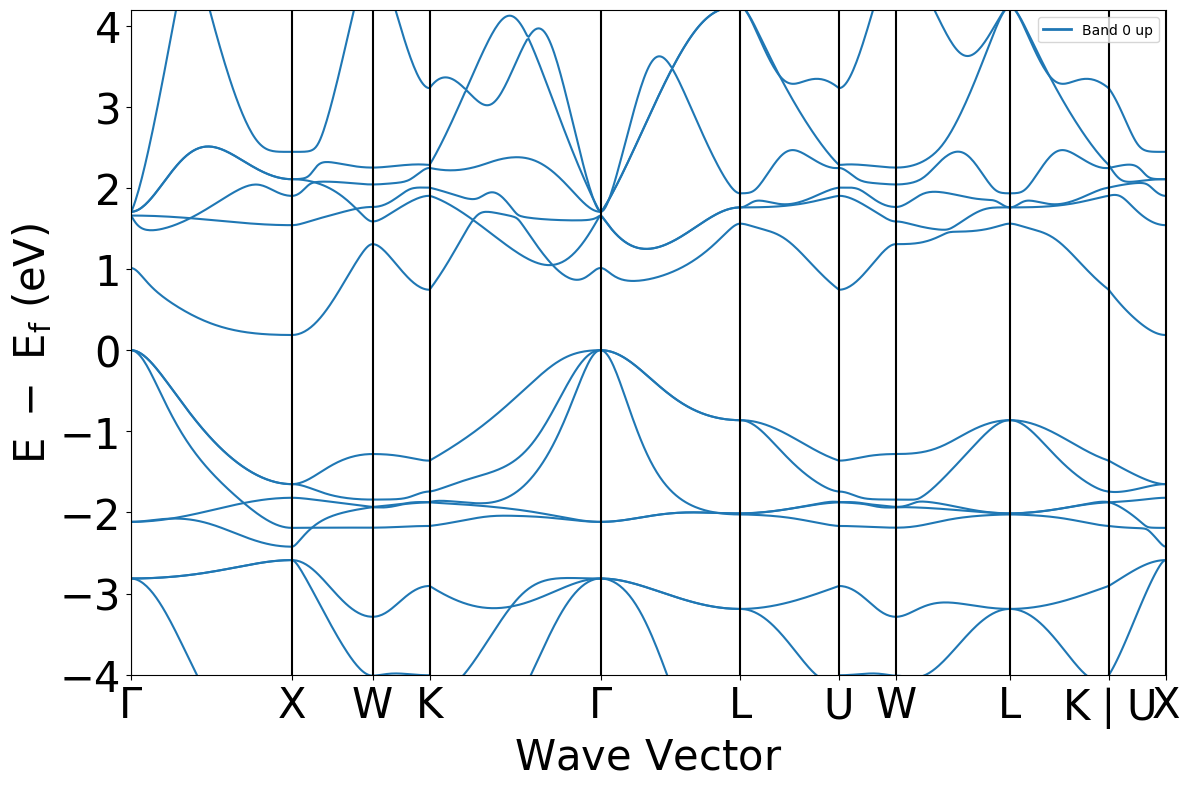

Zone de brillouin du parcours


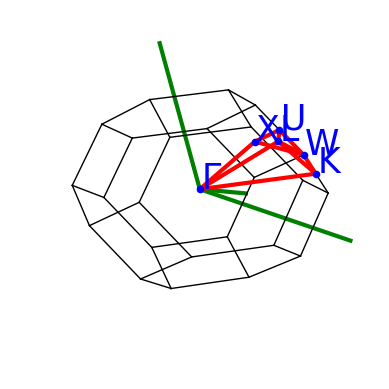

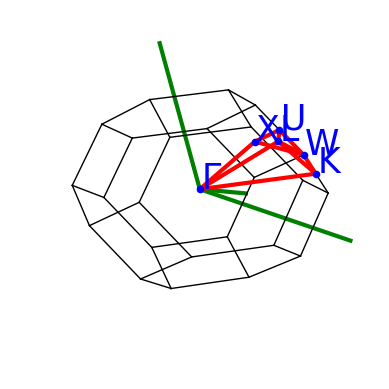

In [273]:
with MPRester(mp_key) as m:
    el_bs = m.get_bandstructure_by_material_id(mp_id)
    
print("Bandes d'énergies du matériau")
BSPlotter(el_bs).show()
print("Zone de brillouin du parcours")
BSPlotter(el_bs).plot_brillouin()

# Bande interdite

Informations Bande interdite:
Énergie: 0.1869000000000005 eV (Semi-Conducteur)
Nature de la bande interdite: indirecte
Direction de transition: \Gamma-X


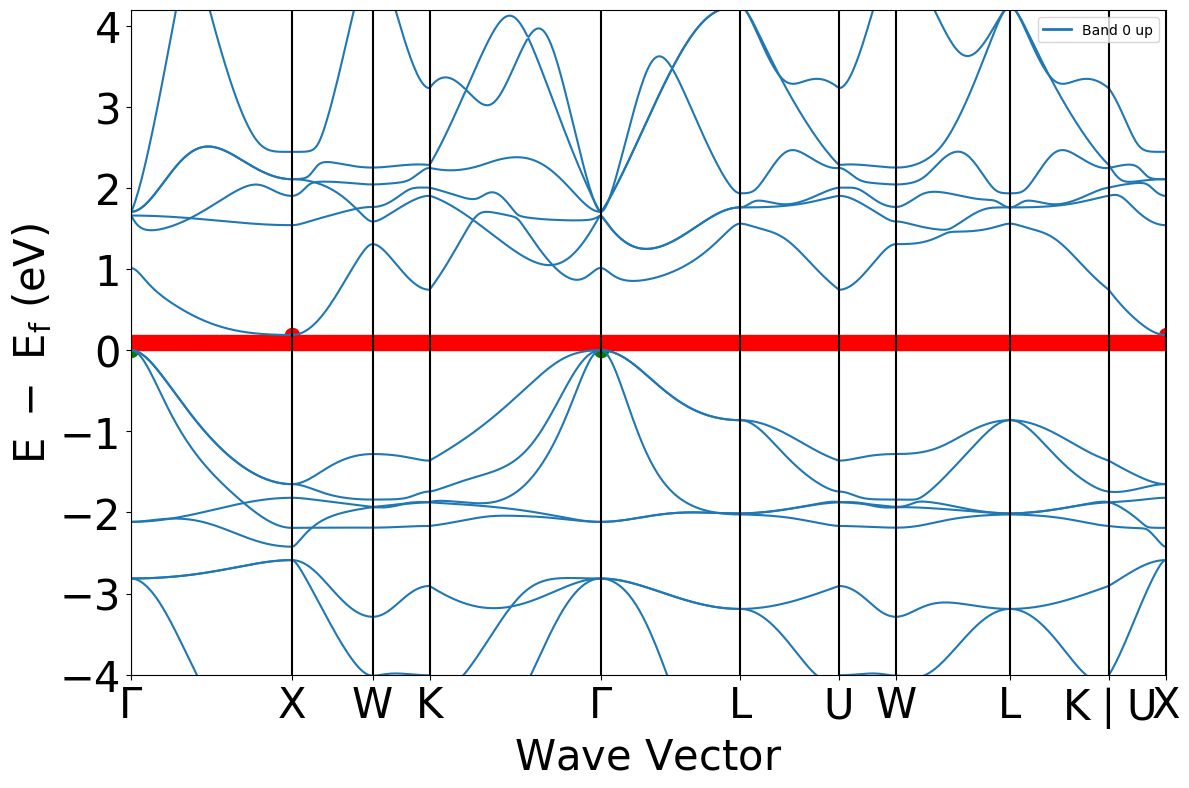

In [274]:
band_gap = el_bs.get_band_gap()
band_gap_energy = band_gap["energy"]
direct = band_gap["direct"]
transition = band_gap["transition"]

print("Informations Bande interdite:")
print(f"Énergie: {band_gap_energy} eV (Semi-Conducteur)")
if direct:
    print("Nature de la bande interdite: directe")
else:
    print("Nature de la bande interdite: indirecte")
print(f"Direction de transition: {transition}")


# afficher la bande interdite
if band_gap_energy > 0:
    BSPlotter(el_bs).get_plot(vbm_cbm_marker=True).fill_between(el_bs_plot.get_xlim(), band_gap_energy, color='red')
plt.show()


# Dispersion

#### Obtention des bandes d'énergies les plus hautes et basses en énergie

In [275]:
data = BSPlotter(el_bs).bs_plot_data()

e0 = data["zero_energy"]
#maximum bande valence
vbm = el_bs.get_vbm()
#minimum bande conduction
cbm = el_bs.get_cbm()

print(f"Energie 0 = {e0:.2f}\n")

print("Dernière bande de valence")
print(f"Energie du maximum de la bande de valence = {vbm['energy']:.2f} eV")
print(f"Indice de bande de valence contenant le maximum  = {vbm['band_index']}\n")

print("Première bande de conduction")
print(f"Energie minimum de la bande de conduction = {cbm['energy']:.2f} eV")
print(f"Indice de bande de conduction contenant le minimum  = {cbm['band_index']}\n")

print("La dernière bande de valence contenant le maximum est la [15] tandis que la première bande de conduction contenant le minimum est la [16]")



Energie 0 = 6.68

Dernière bande de valence
Energie du maximum de la bande de valence = 6.68 eV
Indice de bande de valence contenant le maximum  = defaultdict(<class 'list'>, {<Spin.up: 1>: [13, 14, 15]})

Première bande de conduction
Energie minimum de la bande de conduction = 6.87 eV
Indice de bande de conduction contenant le minimum  = defaultdict(<class 'list'>, {<Spin.up: 1>: [16]})

La dernière bande de valence contenant le maximum est la [15] tandis que la première bande de conduction contenant le minimum est la [16]


#### Obtention des dispersions pour la bande de valence

Informations des pentes :
-------------------------
Pentes de la dernière bande de valence :
   - Index	Valeur
   - 0		-1.6440263593366513
   - 1		0.7387763799829182
   - 2		-0.22923371616497523
   - 3		1.2781516295249735
   - 4		-0.9920622720913291
   - 5		-0.810835642205539
   - 6		0.2292337161649728
   - 7		0.5875874063614345
   - 8		-0.8108356422055396
   - 9		-0.8155538599672069

Informations associées :
-----------------------
Pente maximale de la bande de valence : Index = 0 , Valeur = -1.6440263593366513
Pente minimale de la bande de valence : Index = 6 , Valeur = 0.2292337161649728

Pentes de la première bande de conduction :
   - Index	Valeur
   - 0		-0.8220131796683257
   - 1		2.229471792530664
   - 2		-1.5821069010010158
   - 3		0.2513873431160313
   - 4		0.6283022733780409
   - 5		-1.3239692469379791
   - 6		1.582106901000999
   - 7		0.3555375511772392
   - 8		-1.32396924693798
   - 9		-1.5708423449230275

Informations associées :
-----------------------
Pente maximale de 

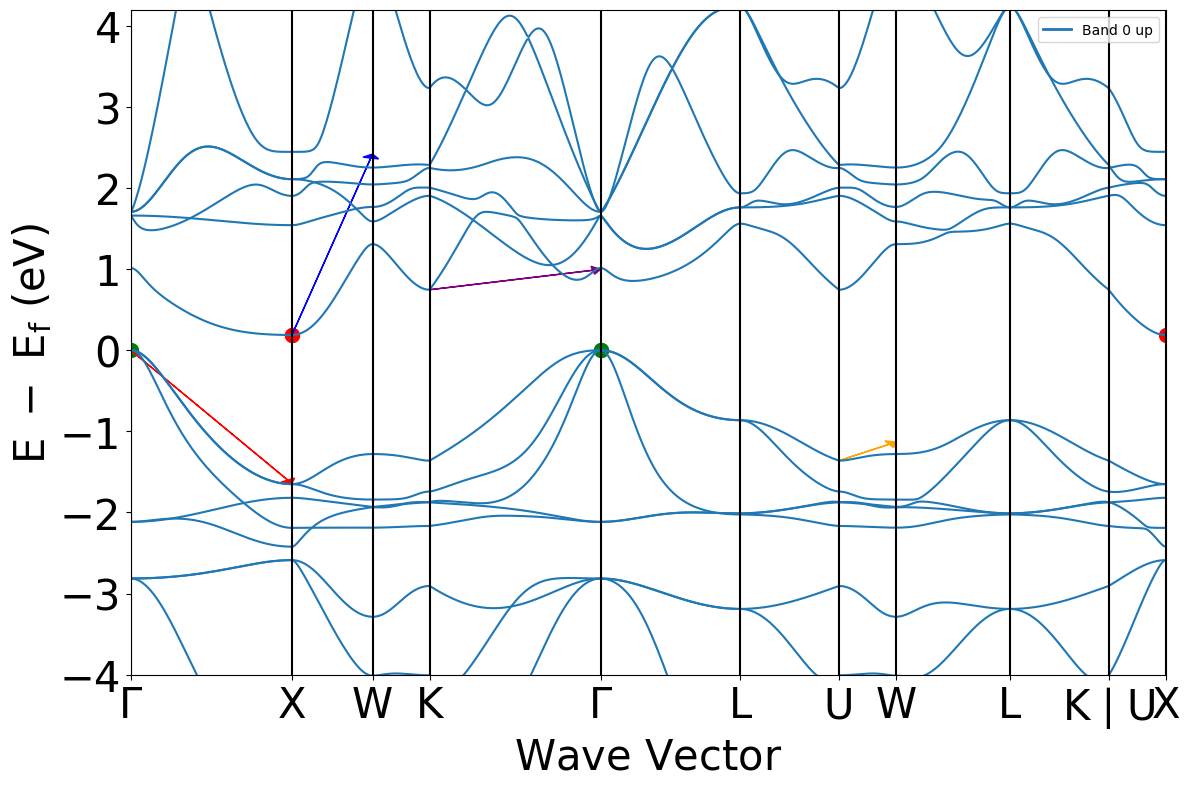

In [276]:
#tableau contenant les différents points du parcours par rapport à l'origine tout à gauche
x = np.unique(data.get("ticks").get("distance"))
#tableau contenant les longueurs de chaque zone
dx = np.diff(x)

#tableau contenant les informations verticales d'energie pour le premier spin pour chaque zone
y = data.get("energy")["1"]

#tableau contenant les index des bandes etudiées respective
vindex = list(vbm['band_index'].values())[0]
cindex = list(cbm['band_index'].values())[0]


#initialisation tableau de pentes pour les 10 zones de parcours
dxdy_valence = np.zeros(10)
dxdy_conduction = np.zeros(10)

for i in range(0,10):
    #calcul pente pour la derniere bande de valence pour chaque parcours
    dxdy_valence[i] = (y[i][vindex[-1]][-1] - y[i][vindex[-1]][0])/dx[i]
    #calcul pente pour la premiere bande de conduction pour chaque parcours
    dxdy_conduction[i] = (y[i][cindex[0]][-1] - y[i][cindex[0]][0]) / dx[i]

#on prend la valeur absolue car on veut connaitre les valeurs les plus petites et grandes de dispersion, le signe devant sera utilisé apres pour donner la direction des fleches
pente_max_valence = np.amax(abs(dxdy_valence))
pente_min_valence = np.amin(abs(dxdy_valence))

pente_max_conduction = np.amax(abs(dxdy_conduction))
pente_min_conduction = np.amin(abs(dxdy_conduction))


#index des pentes pour pouvoir tracer les fleches
index_pente_max_valence = np.argmax(abs(dxdy_valence))
index_pente_min_valence = np.argmin(abs(dxdy_valence))

index_pente_max_conduction = np.argmax(abs(dxdy_conduction))
index_pente_min_conduction = np.argmin(abs(dxdy_conduction))

print("Informations des pentes :")
print("-------------------------")

print("Pentes de la dernière bande de valence :")
print("   - Index\tValeur")
for i, pente in enumerate(dxdy_valence):
    print(f"   - {i}\t\t{pente}")

print("\nInformations associées :")
print("-----------------------")
print("Pente maximale de la bande de valence : Index =", index_pente_max_valence, ", Valeur =", dxdy_valence[index_pente_max_valence])
print("Pente minimale de la bande de valence : Index =", index_pente_min_valence, ", Valeur =", dxdy_valence[index_pente_min_valence])

print("\nPentes de la première bande de conduction :")
print("   - Index\tValeur")
for i, pente in enumerate(dxdy_conduction):
    print(f"   - {i}\t\t{pente}")

print("\nInformations associées :")
print("-----------------------")
print("Pente maximale de la bande de conduction : Index =", index_pente_max_conduction, ", Valeur =", dxdy_conduction[index_pente_max_conduction])
print("Pente minimale de la bande de conduction : Index =", index_pente_min_conduction, ", Valeur =", dxdy_conduction[index_pente_min_conduction])





#plot
BSPlotter(el_bs).get_plot(vbm_cbm_marker=True)
#plt.arrow(x,y,dx,dy,parametres)
#max dispersion valence
plt.arrow(x[index_pente_max_valence], (y[index_pente_max_valence][bande_val_ind[-1]])[0], dx[index_pente_max_valence], dxdy_valence[index_pente_max_valence], color = 'red', head_width=0.1, head_length=0.05, linewidth=1,length_includes_head=True)
#min dipersion valence
plt.arrow(x[index_pente_min_valence], (y[index_pente_min_valence][bande_val_ind[-1]])[0], dx[index_pente_min_valence], dxdy_valence[index_pente_min_valence], color = 'orange', head_width=0.1, head_length=0.05, linewidth=1,length_includes_head=True)
#max dispersion conduction
plt.arrow(x[index_pente_max_conduction], (y[index_pente_max_conduction][bande_cond_ind[0]])[0], dx[index_pente_max_conduction], dxdy_conduction[index_pente_max_conduction], color = 'blue', head_width=0.1, head_length=0.05, linewidth=1,length_includes_head=True)
#min dispersion conduction
plt.arrow(x[index_pente_min_conduction], (y[index_pente_min_conduction][bande_cond_ind[0]])[0], dx[index_pente_min_conduction], dxdy_conduction[index_pente_min_conduction], color = 'purple', head_width=0.1, head_length=0.05, linewidth=1,length_includes_head=True)






## Analyse de la dispersion des bandes électroniques

Pour déterminer la direction dans laquelle la dernière (première) bande de valence (conduction) présente le plus et le moins de dispersion, nous avons examiné les pentes des bandes électroniques pour toutes les directions. En effet, la valeur absolue de la pente nous donne l'intensité de la dispersion. Ainsi, une forte valeur de pente indique une forte dispersion et une faible valeur de pente indique l'inverse.

Nous avons calculé les pentes de la dernière bande de valence pour chaque zone du graphe (Informations bruts présentes au dessus),où chaque index associé à sa valeur de pente correspond au début du parcours étudié :

### Dispersion au sein de la dernière bande de valence

La direction T-X (rouge) présente le plus de dispersion 
- Visuellement : Il s'agit bien de la pente la plus accentuée pour la dernière bande de valence
- Analytiquement : La pente la plus haute en valeur débute à l'index 0, qui correspond au premier point du parcours, c'est à dire T et se finit au prochain point du parcours, c'est à dire X.

La direction U-W (orange) présente le moins de dispersion
- Visuellement : Il s'agit bien de la pente la moins accentuée pour la dernière bande de valence
- Analytiquement : La pente la plus petite en valeur débute à l'index 6, qui correspond au septième point du parcours, c'est à dire U et se finit au prochain point du parcours, c'est à dire W.
### Dispersion au sein de la première bande de conduction

La direction X-W (bleu) présente le plus de dispersion
- Visuellement : Il s'agit bien de la pente la plus accentuée pour la première bande de conduction
- Analytiquement : La pente la plus haute en valeur débute à l'index 1, qui correspond au deuxième point du parcours, c'est à dire X et se finit au prochain point du parcours, c'est à dire W.

La direction K-T (violet) présente le moins de dispersion
- Visuellement : Il s'agit bien de la pente la moins accentuée pour la première bande de conduction
- Analytiquement : La pente la plus petite en valeur débute à l'index 3, qui correspond au quatrième point du parcours, c'est à dire K et se finit au prochain point du parcours, c'est à dire T.



# Masse effective
La masse effective est donnée par $m* = \frac{\hbar^2}{\left( \frac{d^2E}{dk^2} \right)}$

où :
- $m$ est la masse effective,
- $\hbar$ est la constante de Planck réduite,
- $E$ est l'énergie de la bande,
- $k$ est le vecteur d'onde.

En supposant une dispersion parabolique de l'énergie ; $E(k) = ak^2 + bk + c$

Ce qui nous donne la formule finale de la masse effective $m* = \frac{\hbar^2}{2a} = \frac{\hbar^2 .|k|^2}{2.E}$

In [277]:
kpoint_vbm = vbm["kpoint"].cart_coords
kpoint_cbm = cbm["kpoint"].cart_coords
norm_k_vbm = np.linalg.norm(kpoint_vbm)
norm_k_cbm = np.linalg.norm(kpoint_cbm)

hbar = 6.5821e-16 #ev
#sommet
masse_vbm = (hbar**2 * norm_k_vbm**2) / (2 * vbm["energy"])
#base
masse_cbm = (hbar**2 * norm_k_cbm**2) / (2 * cbm["energy"])

print("Pour la dernière bande de valence (point vert):")
print("   - Coordonnées du vecteur k au sommet :", kpoint_vbm)
print("   - Norme du vecteur k au sommet :", norm_k_vbm)
print("   - Masse effective au sommet de la dernière bande de valence :", masse_vbm, "kg.")

print("\nPour la première bande de conduction (point rouge) :")
print("   - Coordonnées du vecteur k à la base :", kpoint_cbm)
print("   - Norme du vecteur k à la base :", norm_k_cbm)
print("   - Masse effective à la base de la première bande de conduction :", masse_cbm, "kg.")


Pour la dernière bande de valence (point vert):
   - Coordonnées du vecteur k au sommet : [0. 0. 0.]
   - Norme du vecteur k au sommet : 0.0
   - Masse effective au sommet de la dernière bande de valence : 0.0 kg.

Pour la première bande de conduction (point rouge) :
   - Coordonnées du vecteur k à la base : [0.         1.00436346 0.        ]
   - Norme du vecteur k à la base : 1.004363458421824
   - Masse effective à la base de la première bande de conduction : 3.1823309246142677e-32 kg.
